In [1]:
# import libraries
from xmitgcm import open_mdsdataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt # from matplotlib import pyplot as plt
import netCDF4 as nc

import scipy.io.netcdf
import glob
import calendar
import pandas as pd
import os
from scipy import interpolate

%matplotlib inline

## 1. Read 1y data

In [2]:
data_dir = '/data2/home/liutongya/data/box32_out/'
ds0 = open_mdsdataset(data_dir, prefix={'theta_ave', 'xyMom_ave', 'etan_ave'}).chunk()
ds0

/data/home/zhangrd/.conda/envs/geo_scipy/lib/python3.7/site-packages/xmitgcm/mds_store.py:914: UserWarning: Couldn't find available_diagnostics.log in /data2/home/liutongya/data/box32_out/ or /data2/home/liutongya/data/box32_out/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


<xarray.Dataset>
Dimensions:  (XC: 1920, YC: 1920, XG: 1920, YG: 1920, Z: 29, Zp1: 30, Zu: 29, Zl: 29, time: 360)
Coordinates: (12/30)
  * XC       (XC) >f4 0.01562 0.04688 0.07812 0.1094 ... 59.89 59.92 59.95 59.98
  * YC       (YC) >f4 0.01562 0.04688 0.07812 0.1094 ... 59.89 59.92 59.95 59.98
  * XG       (XG) >f4 0.0 0.03125 0.0625 0.09375 ... 59.88 59.91 59.94 59.97
  * YG       (YG) >f4 0.0 0.03125 0.0625 0.09375 ... 59.88 59.91 59.94 59.97
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -40.0 ... -2.75e+03 -3.25e+03 -3.75e+03
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2.5e+03 -3e+03 -3.5e+03 -4e+03
    ...       ...
    maskC    (Z, YC, XC) bool dask.array<chunksize=(29, 1920, 1920), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(29, 1920, 1920), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(29, 1920, 1920), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(29,), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 60 days 00:04:48 ... 61 days 04:48:00
Data variables:
    THETA    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 29, 1920, 1920), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) float32 dask.array<chunksize=(1, 29, 1920, 1920), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) float32 dask.array<chunksize=(1, 29, 1920, 1920), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 29, 1920, 1920), meta=np.ndarray>
    ETAN     (time, YC, XC) float32 dask.array<chunksize=(1, 1920, 1920), meta=np.ndarray>
    oceQsw   (time, YC, XC) float32 dask.array<chunksize=(1, 1920, 1920), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [3]:
# 从360天×1920×1920切片出副热带和锋面区(from daily data) 20240615：    
sub_1y = ds0.sel(XC=slice(ds0.XC[32*5-1],ds0.XC[32*55]) , YC=slice(ds0.YC[32*5-1],ds0.YC[32*25]) ,
                 XG=slice(ds0.XC[32*5-1],ds0.XC[32*55+1]) , YG=slice(ds0.YC[32*5-1],ds0.YC[32*25+1]) ,)
frt_1y = ds0.sel(XC=slice(ds0.XC[32*5-1],ds0.XC[32*55]) , YC=slice(ds0.YC[32*25-1],ds0.YC[32*45]) ,
                 XG=slice(ds0.XC[32*5-1],ds0.XC[32*55+1]) , YG=slice(ds0.YC[32*25-1],ds0.YC[32*45+1]) ,)
sub_1y

<xarray.Dataset>
Dimensions:  (XC: 1602, YC: 642, XG: 1602, YG: 642, Z: 29, Zp1: 30, Zu: 29, Zl: 29, time: 360)
Coordinates: (12/30)
  * XC       (XC) >f4 4.984 5.016 5.047 5.078 5.109 ... 54.92 54.95 54.98 55.02
  * YC       (YC) >f4 4.984 5.016 5.047 5.078 5.109 ... 24.92 24.95 24.98 25.02
  * XG       (XG) >f4 5.0 5.031 5.062 5.094 5.125 ... 54.94 54.97 55.0 55.03
  * YG       (YG) >f4 5.0 5.031 5.062 5.094 5.125 ... 24.94 24.97 25.0 25.03
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -40.0 ... -2.75e+03 -3.25e+03 -3.75e+03
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2.5e+03 -3e+03 -3.5e+03 -4e+03
    ...       ...
    maskC    (Z, YC, XC) bool dask.array<chunksize=(29, 642, 1602), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(29, 642, 1602), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(29, 642, 1602), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(29,), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 60 days 00:04:48 ... 61 days 04:48:00
Data variables:
    THETA    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 29, 642, 1602), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) float32 dask.array<chunksize=(1, 29, 642, 1602), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) float32 dask.array<chunksize=(1, 29, 642, 1602), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 29, 642, 1602), meta=np.ndarray>
    ETAN     (time, YC, XC) float32 dask.array<chunksize=(1, 642, 1602), meta=np.ndarray>
    oceQsw   (time, YC, XC) float32 dask.array<chunksize=(1, 642, 1602), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [ ]:
#####################
#  画 SSH 和 theta  #
#####################
elev=np.linspace(-1.5,1.5,11)
tlev=np.linspace(2,28,14)
# elev,tlev

for i in np.arange(360):
# for i in np.arange(150,151):
    fig = plt.figure(figsize=(12, 6))
    pos1=[0.06,0.55,0.62,0.4]
    pos2=[0.7,0.55,0.28,0.4]
    pos3=[0.06,0.10,0.62,0.4]
    pos4=[0.7,0.10,0.28,0.4]
    
    ax1=plt.axes(pos1)
    frt_1y.THETA[i,0,:,:].plot(cmap='Spectral_r',levels=tlev,cbar_kwargs=dict(label=r''))
    # tt = frt_1y.THETA[i,0,:,:].plot.contour(levels=tlev,colors='k', linewidths=0.3)
    # plt.clabel(tt, inline=1, fontsize=10)
    # frt_1y.ETAN[i,:,:].plot(levels=elev,cbar_kwargs=dict(label=r''))
    ee = frt_1y.ETAN[i,:,:].plot.contour(levels=elev,colors='k', linewidths=0.6)
    plt.clabel(ee, inline=1, fontsize=10)
    # plt.quiver(X1,Y1,qu,qv,scale=2)
    plt.title('SST & SSH in day '+str(i).zfill(3))
    plt.xlabel('')
    plt.ylabel('Lat(°N)')
    
    ax2=plt.axes(pos2)
    t1_xmean[i,:26,:].plot(cmap='Spectral_r',levels=tlev,cbar_kwargs=dict(label=r''))
    tt = t1_xmean[i,:26,:].plot.contour(levels=tlev,colors='k', linewidths=0.6)
    plt.clabel(tt, inline=1, fontsize=10)
    plt.title('theta profile in day '+str(i).zfill(3))
    plt.xlabel('')
    plt.ylabel('Depth(m)')
    
    ax3=plt.axes(pos3)
    sub_1y.THETA[i,0,:,:].plot(cmap='Spectral_r',levels=tlev,cbar_kwargs=dict(label=r''))
    # tt = sub_1y.THETA[i,0,:,:].plot.contour(levels=tlev,colors='k', linewidths=0.3)
    # plt.clabel(tt, inline=1, fontsize=10)
    # sub_1y.ETAN[i,:,:].plot(levels=elev,cbar_kwargs=dict(label=r''))
    ee = sub_1y.ETAN[i,:,:].plot.contour(levels=elev,colors='k', linewidths=0.6)
    plt.clabel(ee, inline=1, fontsize=10)
    plt.title('')
    plt.xlabel('Lon(°E)')
    plt.ylabel('Lat(°N)')
    
    ax4=plt.axes(pos4)
    t2_xmean[i,:26,:].plot(cmap='Spectral_r',levels=tlev,cbar_kwargs=dict(label=r''))
    tt = t2_xmean[i,:26,:].plot.contour(levels=tlev,colors='k', linewidths=0.6)
    plt.clabel(tt, inline=1, fontsize=10)
    plt.title('')
    plt.xlabel('Lat(°N)')
    plt.ylabel('Depth(m)')
    
    savePath = '/data/home/zhangrd/Pictures/1y_snapGIF/SSH&T/'
    saveName = 'day'+str(i).zfill(3)+'.png'

    fp0 = os.path.exists(savePath)
    if not fp0:
        os.makedirs(savePath)
    plt.savefig(savePath + saveName, dpi=150)
    plt.close()

In [ ]:
import imageio.v2 as imageio # version of imageio
import os
import os.path

png_dir = '/data/home/zhangrd/Pictures/1y_snapGIF/SSH&T/'
images = []
pngfiles = os.listdir(png_dir)
pngfiles.sort()
for file_name in pngfiles:
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('/data/home/zhangrd/Pictures/1y_snapGIF/SSH&T/SSH&T.gif', images, duration=0.2)

In [5]:
u1_surf, v1_surf, w1_surf = frt_1y.UVEL[:,0,:,:]*86400, frt_1y.VVEL[:,0,:,:]*86400, frt_1y.WVEL[:,0,:,:]*86400
u2_surf, v2_surf, w2_surf = sub_1y.UVEL[:,0,:,:]*86400, sub_1y.VVEL[:,0,:,:]*86400, sub_1y.WVEL[:,0,:,:]*86400
u1_300m, v1_300m, w1_300m = np.mean(frt_1y.UVEL[:,10:12,:,:]*86400,1), np.mean(frt_1y.VVEL[:,10:12,:,:]*86400,1), frt_1y.WVEL[:,11,:,:]*86400
u2_300m, v2_300m, w2_300m = np.mean(sub_1y.UVEL[:,10:12,:,:]*86400,1), np.mean(sub_1y.VVEL[:,10:12,:,:]*86400,1), sub_1y.WVEL[:,11,:,:]*86400

# X1,Y1 = np.meshgrid(frt_1y.XC,frt_1y.YC)
# X2,Y2 = np.meshgrid(sub_1y.XC,sub_1y.YC)

# qu1_surf = np.zeros([360,642,1602])*np.nan
# qv1_surf = np.zeros([360,642,1602])*np.nan
# qu1_300m = np.zeros([360,642,1602])*np.nan
# qv1_300m = np.zeros([360,642,1602])*np.nan
# qu2_surf = np.zeros([360,642,1602])*np.nan
# qv2_surf = np.zeros([360,642,1602])*np.nan
# qu2_300m = np.zeros([360,642,1602])*np.nan
# qv2_300m = np.zeros([360,642,1602])*np.nan

# # for t in np.arange(361):
# for t in np.arange(150,151):
#     for j in np.arange(0,642,64):
#         for i in np.arange(0,1602,64):
#             qu1_surf[t,j,i] = u1_surf[t,j,i]
#             qv1_surf[t,j,i] = v1_surf[t,j,i]
#             qu1_300m[t,j,i] = u1_300m[t,j,i]
#             qv1_300m[t,j,i] = v1_300m[t,j,i]
#             qu2_surf[t,j,i] = u2_surf[t,j,i]
#             qv2_surf[t,j,i] = v2_surf[t,j,i]
#             qu2_300m[t,j,i] = u2_300m[t,j,i]
#             qv2_300m[t,j,i] = v2_300m[t,j,i]

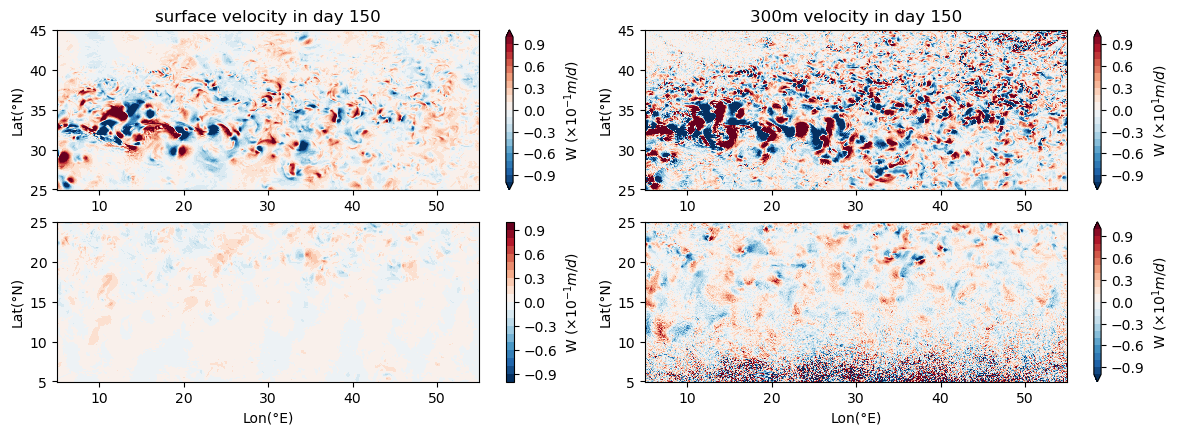

In [7]:
#####################
#    画垂向流速 w    #
#####################
wlev=np.linspace(-1,1,21)
# wlev
# for i in np.arange(360):
for i in np.arange(150,151):
    fig = plt.figure(figsize=(12, 4))
    pos1=[0.06,0.58,0.44,0.4]
    pos2=[0.55,0.58,0.44,0.4]
    pos3=[0.06,0.1,0.44,0.4]
    pos4=[0.55,0.1,0.44,0.4]
    
    ax1=plt.axes(pos1)
    (w1_surf[i,:,:]*10).plot(cmap='RdBu_r',levels=wlev,cbar_kwargs=dict(label=r'W ($ \times 10^{-1} m/d$)'))
    # plt.quiver(X1,Y1,qu1_surf,qv1_surf,scale=2)
    plt.title('surface velocity in day '+str(i).zfill(3))
    plt.xlabel('')
    plt.ylabel('Lat(°N)')
    
    ax2=plt.axes(pos2)
    (w1_300m[i,:,:]*.1).plot(cmap='RdBu_r',levels=wlev,cbar_kwargs=dict(label=r'W ($ \times 10^{1} m/d$)'))
    # plt.quiver(X1,Y1,qu1_300m,qv1_300m,scale=2)
    plt.title('300m velocity in day '+str(i).zfill(3))
    plt.xlabel('')
    plt.ylabel('Lat(°N)')
    
    ax3=plt.axes(pos3)
    (w2_surf[i,:,:]*10).plot(cmap='RdBu_r',levels=wlev,cbar_kwargs=dict(label=r'W ($ \times 10^{-1} m/d$)'))
    # plt.quiver(X1,Y1,qu2_surf,qv2_surf,scale=2)
    plt.title('')
    plt.xlabel('Lon(°E)')
    plt.ylabel('Lat(°N)')
    
    ax4=plt.axes(pos4)
    (w2_300m[i,:,:]*.1).plot(cmap='RdBu_r',levels=wlev,cbar_kwargs=dict(label=r'W ($ \times 10^{1} m/d$)'))
    # plt.quiver(X1,Y1,qu2_300m,qv2_300m,scale=2)
    plt.title('')
    plt.xlabel('Lon(°E)')
    plt.ylabel('Lat(°N)')
    
    plt.show()
    

In [ ]:
frt_1y= xr.open_dataset('/data/home/zhangrd/frt_1y.nc')
frt_1y

## 2. 写为nc文件

In [8]:
# Subtro
for t in np.arange(360):
    zz = sub_1y.ETAN.data[t,:,:]
    uu = sub_1y.UVEL.data[t,0,:,:]
    vv = sub_1y.VVEL.data[t,0,:,:]
    znew = zz[np.newaxis,:,:].astype('float64')
    unew = uu[np.newaxis,:,:].astype('float64')
    vnew = vv[np.newaxis,:,:].astype('float64')
    
    znew[0, 0, :] = np.nan
    
    zeta_ds = xr.Dataset(data_vars=dict(
                                 adt    = (["time", "latitude","longitude"], znew[:,:,:]),
                                 u      = (["time", "latitude","longitude"], unew[:,:,:]),
                                 v      = (["time", "latitude","longitude"], vnew[:,:,:])),
                                 coords = {"latitude": sub_1y.YC.values, "longitude": sub_1y.XC.values, "time": [t]})
    zeta_ds['adt'].attrs['units'] = 'm'
    zeta_ds['u'].attrs['units']   = 'meter second^-1'
    zeta_ds['v'].attrs['units']   = 'meter second^-1'
    
    nc_out = '/data/home/zhangrd/Data/sub_1ync/input'+str(t).zfill(3)+'.nc'
    zeta_ds.to_netcdf(nc_out)

In [9]:
# Frt
for t in np.arange(360):
    zz = frt_1y.ETAN.data[t,:,:]
    uu = frt_1y.UVEL.data[t,0,:,:]
    vv = frt_1y.VVEL.data[t,0,:,:]
    znew = zz[np.newaxis,:,:].astype('float64')
    unew = uu[np.newaxis,:,:].astype('float64')
    vnew = vv[np.newaxis,:,:].astype('float64')
    
    znew[0, 0, :] = np.nan
    
    zeta_ds = xr.Dataset(data_vars=dict(
                                 adt    = (["time", "latitude","longitude"], znew[:,:,:]),
                                 u      = (["time", "latitude","longitude"], unew[:,:,:]),
                                 v      = (["time", "latitude","longitude"], vnew[:,:,:])),
                                 coords = {"latitude": frt_1y.YC.values, "longitude": frt_1y.XC.values, "time": [t]})
    zeta_ds['adt'].attrs['units'] = 'm'
    zeta_ds['u'].attrs['units']   = 'meter second^-1'
    zeta_ds['v'].attrs['units']   = 'meter second^-1'
    
    nc_out = '/data/home/zhangrd/Data/frt_1ync/input'+str(t).zfill(3)+'.nc'
    zeta_ds.to_netcdf(nc_out)

### 验证nc文件

In [10]:
dsnc = xr.open_dataset('/data/home/zhangrd/Data/sub_1ync/input100.nc')
# dsnc
# np.isnan(dsnc.u.data).sum(), np.isnan(dsnc.v.values).sum(), np.isnan(dsnc.adt.data).sum() # 检查数据中的nan值数量

<a list of 10 text.Text objects>

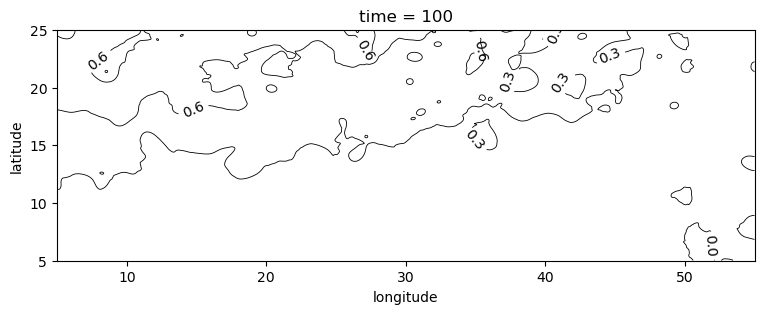

In [13]:
fig = plt.figure(figsize=(9, 3))
# dsnc.adt[0,:,:].plot.contourf(cmap='jet', levels=200)
ee = dsnc.adt[0,:,:].plot.contour(levels=elev,colors='k', linewidths=0.6)
plt.clabel(ee, inline=1, fontsize=10)

In [14]:
dsnc = xr.open_dataset('/data/home/zhangrd/Data/frt_1ync/input100.nc')
# dsnc
# np.isnan(dsnc.u.data).sum(), np.isnan(dsnc.v.values).sum(), np.isnan(dsnc.adt.data).sum() # 检查数据中的nan值数量

<a list of 27 text.Text objects>

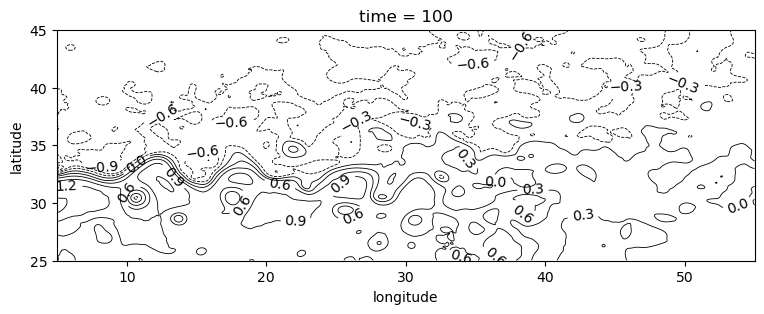

In [15]:
fig = plt.figure(figsize=(9, 3))
# dsnc.adt[0,:,:].plot.contourf(cmap='jet', levels=200)
ee = dsnc.adt[0,:,:].plot.contour(levels=elev,colors='k', linewidths=0.6)
plt.clabel(ee, inline=1, fontsize=10)

## 3. 涡旋识别

In [2]:
from py_eddy_tracker import start_logger
from datetime import datetime
from py_eddy_tracker.dataset.grid import RegularGridDataset, UnRegularGridDataset
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import numpy as np

In [ ]:
# Subtro
start_logger().setLevel('INFO') # Available options: ERROR, WARNING, INFO, DEBUG

for t in np.arange(360):
    nc_in = '/data/home/zhangrd/Data/sub_1ync/input'+str(t).zfill(3)+'.nc'
    h = RegularGridDataset( nc_in, 'longitude', 'latitude')
    h.add_uv("adt")
    h.bessel_high_filter('adt', 500, order=3)  # COST LOTS of TIME
    
    date = datetime.strptime('2022'[2:4]+str(t+1).zfill(3), '%y%j')
    
    a, c = h.eddy_identification(
           'adt', 'u', 'v', # Variables used for identification
            date, # Days of identification
            0.002, # step between two isolines of detection (m)
            pixel_limit=(500, 5000), # Min and max pixel count for valid contour
            shape_error=55, # Error max (%) between ratio of circle fit and contour
            )
    
    with Dataset(date.strftime('/data/home/zhangrd/Data/sub_1yIdfy/Anticycl/Anticyclonic_%Y%m%d.nc'), 'w') as h:
        a.to_netcdf(h)
    with Dataset(date.strftime('/data/home/zhangrd/Data/sub_1yIdfy/Cycl/Cyclonic_%Y%m%d.nc'), 'w') as h:
        c.to_netcdf(h)

WARNING 2024-06-18 14:34:47,948 grid.__init__ :
	We assume pixel position of grid is centered for /data/home/zhangrd/Data/sub_1ync/input000.nc
INFO 2024-06-18 14:34:48,011 grid.add_uv :
	Add u/v variable with stencil method
INFO 2024-06-18 14:41:47,787 grid.eddy_identification :
	We will apply on step a factor to be coherent with grid : 1.000000
INFO 2024-06-18 14:41:47,811 eddy_feature.__init__ :
	Start computing iso lines
INFO 2024-06-18 14:41:47,827 eddy_feature.__init__ :
	Start computing iso lines with 224 levels from -0.260000 to 0.186000 ...
INFO 2024-06-18 14:41:49,418 eddy_feature.__init__ :
	Finish computing iso lines
INFO 2024-06-18 14:41:49,579 eddy_feature.__init__ :
	Repair 1020 closed contours and 0 almost closed contours / 6120 contours
WARNING 2024-06-18 14:41:54,015 grid.__init__ :
	We assume pixel position of grid is centered for /data/home/zhangrd/Data/sub_1ync/input001.nc
INFO 2024-06-18 14:41:54,054 grid.add_uv :
	Add u/v variable with stencil method
INFO 2024-06-

In [ ]:
# frt
start_logger().setLevel('INFO') # Available options: ERROR, WARNING, INFO, DEBUG

for t in np.arange(360):
    nc_in = '/data/home/zhangrd/Data/frt_1ync/input'+str(t).zfill(3)+'.nc'
    h = RegularGridDataset( nc_in, 'longitude', 'latitude')
    h.add_uv("adt")
    h.bessel_high_filter('adt', 700, order=3)  # COST LOTS of TIME
    
    date = datetime.strptime('2022'[2:4]+str(t+1).zfill(3), '%y%j')
    
    a, c = h.eddy_identification(
           'adt', 'u', 'v', # Variables used for identification
            date, # Days of identification
            0.002, # step between two isolines of detection (m)
            pixel_limit=(500, 5000), # Min and max pixel count for valid contour
            shape_error=55, # Error max (%) between ratio of circle fit and contour
            )
    
    with Dataset(date.strftime('/data/home/zhangrd/Data/frt_1yIdfy/Anticycl/Anticyclonic_%Y%m%d.nc'), 'w') as h:
        a.to_netcdf(h)
    with Dataset(date.strftime('/data/home/zhangrd/Data/frt_1yIdfy/Cycl/Cyclonic_%Y%m%d.nc'), 'w') as h:
        c.to_netcdf(h)

WARNING 2024-06-21 14:02:42,184 grid.__init__ :
	We assume pixel position of grid is centered for /data/home/zhangrd/Data/frt_1ync/input000.nc
INFO 2024-06-21 14:02:42,400 grid.add_uv :
	Add u/v variable with stencil method
INFO 2024-06-21 14:15:20,141 grid.eddy_identification :
	We will apply on step a factor to be coherent with grid : 1.000000
INFO 2024-06-21 14:15:20,166 eddy_feature.__init__ :
	Start computing iso lines
INFO 2024-06-21 14:15:20,234 eddy_feature.__init__ :
	Start computing iso lines with 1002 levels from -1.056000 to 0.946000 ...
INFO 2024-06-21 14:15:27,535 eddy_feature.__init__ :
	Finish computing iso lines
INFO 2024-06-21 14:15:28,137 eddy_feature.__init__ :
	Repair 3473 closed contours and 6 almost closed contours / 20972 contours
WARNING 2024-06-21 14:15:44,242 grid.__init__ :
	We assume pixel position of grid is centered for /data/home/zhangrd/Data/frt_1ync/input001.nc
INFO 2024-06-21 14:15:44,303 grid.add_uv :
	Add u/v variable with stencil method
INFO 2024-0